In [12]:
import pandas as pd
import numpy as np
import tensorflow as tf
import os
import matplotlib.pyplot as plt

In [13]:
CSV_PATH = '/mnt/f/course/embedded_system/dataset/RAF-DB_DATASET/test_labels.csv'
IMG_DIR = '/mnt/f/course/embedded_system/dataset/RAF-DB_DATASET/DATASET/test'
BATCH_SIZE = 32

In [14]:
# 讀取測試集 CSV
df = pd.read_csv(CSV_PATH, header=None, names=['image', 'label'])
df['image'] = df['image'].astype(str)

# 定義目標類別（與訓練時相同）
target_negatives = ['1', '4', '7']
target_positive = ['6']

# 篩選目標類別（測試集不做 downsampling，使用全部資料）
df_neg = df[df['label'].isin(target_negatives)].copy()
df_pos = df[df['label'].isin(target_positive)].copy()
print(f"正樣本 (Anger) 數量: {len(df_pos)}")
print(f"負樣本 (Non-Anger) 數量: {len(df_neg)}")

# 合併所有測試資料
df_test = pd.concat([df_pos, df_neg])
df_test = df_test.reset_index(drop=True)

# 6 -> '1' (Anger), Others -> '0' (Non-Anger)
df_test['binary_label'] = df_test['label'].apply(lambda x: '1' if str(x) == '6' else '0')

# 建立完整的圖片路徑（影像在標籤子目錄中）
df_test['image_full_path'] = df_test.apply(
    lambda row: os.path.join(IMG_DIR, str(row['label']), row['image']), 
    axis=1
)

print(f"\n測試集標籤分佈:")
print(df_test['binary_label'].value_counts())

正樣本 (Anger) 數量: 162
負樣本 (Non-Anger) 數量: 2194

測試集標籤分佈:
binary_label
0    2194
1     162
Name: count, dtype: int64


In [15]:
# GPU 設定
def setup_gpu():
    gpus = tf.config.experimental.list_physical_devices('GPU')
    if gpus:
        try:
            for gpu in gpus:
                tf.config.experimental.set_memory_growth(gpu, True)
            print(f"已偵測到 GPU: {len(gpus)} 個，並開啟記憶體動態增長")
        except RuntimeError as e:
            print(e)
    else:
        print("未偵測到 GPU，將使用 CPU")

setup_gpu()


已偵測到 GPU: 1 個，並開啟記憶體動態增長


In [16]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet50 import preprocess_input

test_data_generator = ImageDataGenerator(
    preprocessing_function=preprocess_input
)

test_generator = test_data_generator.flow_from_dataframe(
    dataframe=df_test,
    directory=None,
    x_col='image_full_path',
    y_col='binary_label',
    target_size=(224, 224),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    classes=['0', '1'],
    shuffle=False
)


Found 2356 validated image filenames belonging to 2 classes.


In [17]:
# 載入訓練好的模型
MODEL_PATH = '/mnt/f/course/embedded_system/dataset/RAF-DB_DATASET/model/1224_0022best_anger_model.keras'
model = tf.keras.models.load_model(MODEL_PATH)
print("模型載入成功！")
model.summary()


模型載入成功！


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resnet50 (Functional)           │ (None, 7, 7, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 54,019,461 (206.07 MB)

 Trainable params: 14,953,473 (57.04 MB)

 Non-trainable params: 9,159,040 (34.94 MB)

 Optimizer params: 29,906,948 (114.09 MB)

In [18]:
# 進行預測
print("開始進行測試集預測...")
y_pred_proba = model.predict(test_generator, verbose=1)
y_pred = (y_pred_proba > 0.5).astype(int).flatten()

# 取得真實標籤
y_true = test_generator.classes

print(f"\n預測完成！")
print(f"測試樣本數: {len(y_true)}")
print(f"預測為 Anger 的數量: {sum(y_pred)}")
print(f"預測為 Non-Anger 的數量: {len(y_pred) - sum(y_pred)}")


開始進行測試集預測...


/home/guan/cuda_test/tf-venv/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


74/74 ━━━━━━━━━━━━━━━━━━━━ 40s 499ms/step

預測完成！
測試樣本數: 2356
預測為 Anger 的數量: 167
預測為 Non-Anger 的數量: 2189


In [19]:
# 計算評估指標
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report, roc_auc_score, roc_curve
)

accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)
roc_auc = roc_auc_score(y_true, y_pred_proba)

print("=" * 60)
print("測試集評估結果")
print("=" * 60)
print(f"Accuracy:  {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1-Score:  {f1:.4f}")
print(f"ROC-AUC:   {roc_auc:.4f}")
print("=" * 60)

print("\n分類報告:")
print(classification_report(y_true, y_pred, target_names=['Non-Anger (0)', 'Anger (1)']))


測試集評估結果
Accuracy:  0.9512
Precision: 0.6407
Recall:    0.6605
F1-Score:  0.6505
ROC-AUC:   0.9383

分類報告:
               precision    recall  f1-score   support

Non-Anger (0)       0.97      0.97      0.97      2194
    Anger (1)       0.64      0.66      0.65       162

     accuracy                           0.95      2356
    macro avg       0.81      0.82      0.81      2356
 weighted avg       0.95      0.95      0.95      2356



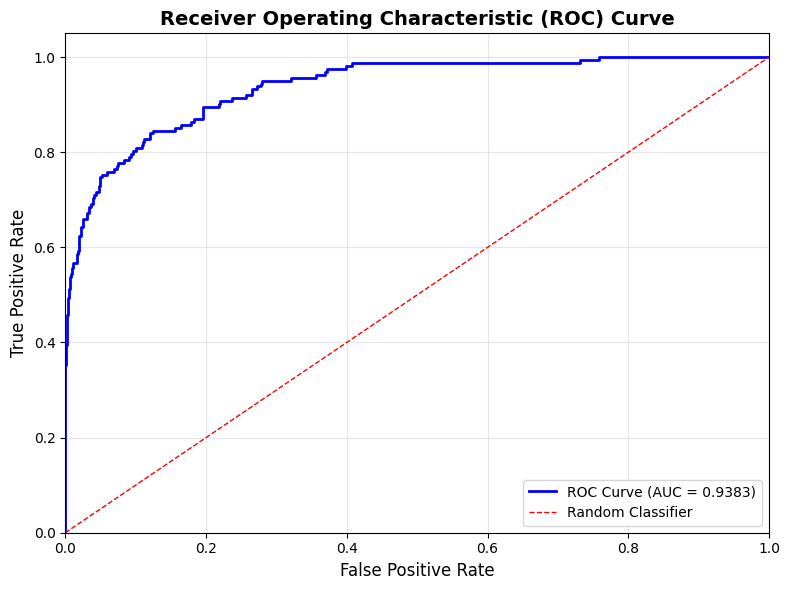

In [20]:
# 繪製 ROC 曲線
fpr, tpr, thresholds = roc_curve(y_true, y_pred_proba)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, 'b-', linewidth=2, label=f'ROC Curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], 'r--', linewidth=1, label='Random Classifier')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('Receiver Operating Characteristic (ROC) Curve', fontsize=14, fontweight='bold')
plt.legend(loc='lower right')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


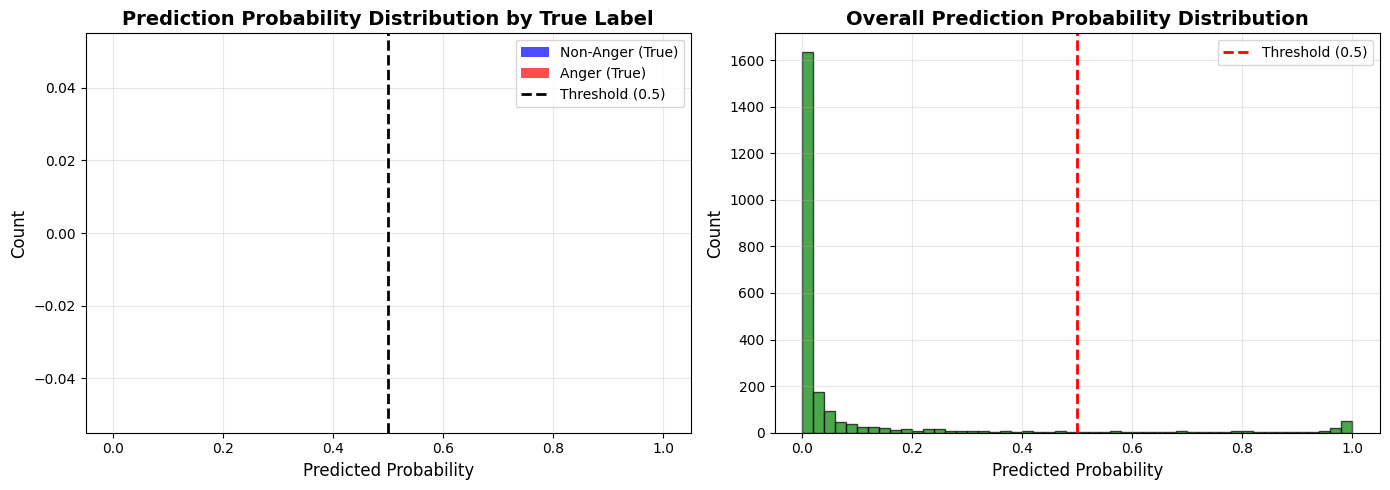

In [21]:
# 繪製預測機率分布
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# 按真實標籤分組的預測機率分布
pred_neg = y_pred_proba[y_true == 0].flatten()
pred_pos = y_pred_proba[y_true == 1].flatten()

axes[0].hist(pred_neg, bins=50, alpha=0.7, label='Non-Anger (True)', color='blue')
axes[0].hist(pred_pos, bins=50, alpha=0.7, label='Anger (True)', color='red')
axes[0].axvline(x=0.5, color='black', linestyle='--', linewidth=2, label='Threshold (0.5)')
axes[0].set_xlabel('Predicted Probability', fontsize=12)
axes[0].set_ylabel('Count', fontsize=12)
axes[0].set_title('Prediction Probability Distribution by True Label', fontsize=14, fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# 整體預測機率分布
axes[1].hist(y_pred_proba.flatten(), bins=50, alpha=0.7, color='green', edgecolor='black')
axes[1].axvline(x=0.5, color='red', linestyle='--', linewidth=2, label='Threshold (0.5)')
axes[1].set_xlabel('Predicted Probability', fontsize=12)
axes[1].set_ylabel('Count', fontsize=12)
axes[1].set_title('Overall Prediction Probability Distribution', fontsize=14, fontweight='bold')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()
